Process time was 3.129729999999995


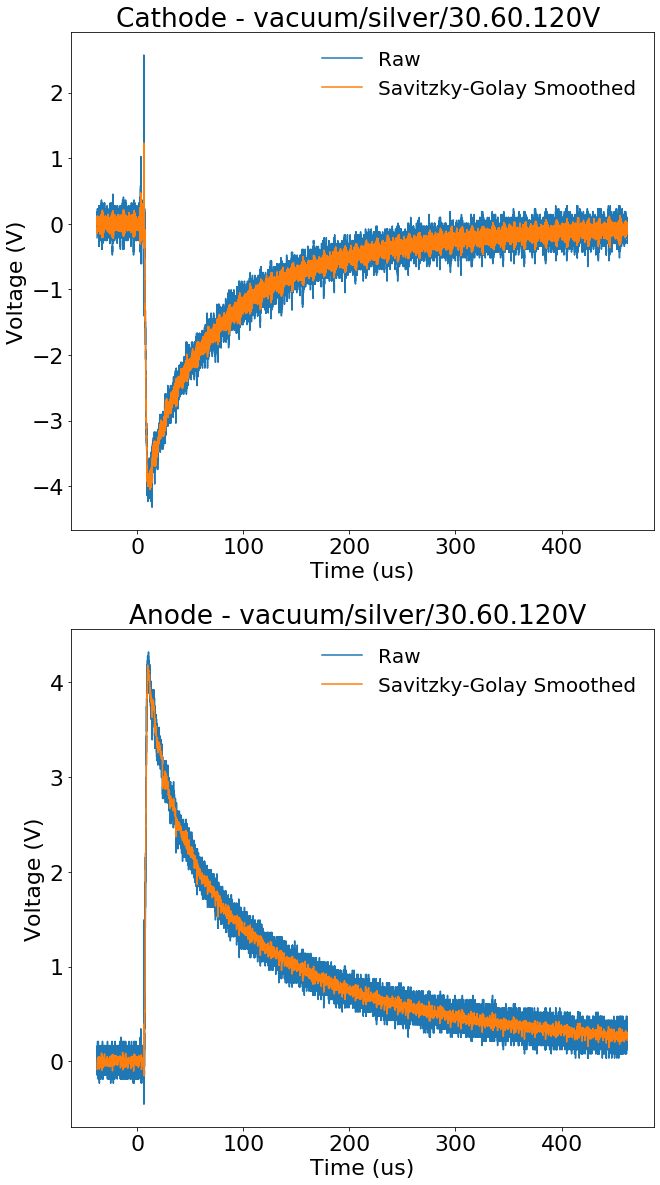

In [45]:
from struct import unpack, calcsize
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import savgol_filter
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

#params_pattern defines the structure we want to read in 
params_pattern = '=IBdddd' # (num_samples, sample_bytes, v_off, v_scale, h_off, h_scale, [samples]) ...
struct_size = calcsize(params_pattern)
#print(struct_size)

#Function to unpack the header
def unpackHeader(header):
    sHeader = unpack(params_pattern,header)
    numSamples=sHeader[0]
    bytesPerSample=sHeader[1]
    v_off=sHeader[2]
    v_scale=sHeader[3]
    h_off=sHeader[4]
    h_scale=sHeader[5]
    return numSamples,bytesPerSample,v_off,v_scale,h_off,h_scale

#Just some timing call for debugging
startTime = time.process_time()

#Now the main loop which is looping over both the cathode file and the anode file
with open("/Users/rjn/dune/purity/UCL/vacuum/silver/30.60.120Vcm.ch4.traces","rb") as fCat, open("/Users/rjn/dune/purity/UCL/vacuum/silver/30.60.120Vcm.ch3.traces","rb") as fAn:
    anodeList=[]
    cathodeList=[]
    while True:
        #First read and unpack the headers
        header = fCat.read(struct_size)
        headerAn = fAn.read(struct_size)
        if not header: break
        numSamples,bytesPerSample,v_off,v_scale,h_off,h_scale=unpackHeader(header) 
        if not headerAn: break
        numSamplesAn,bpsAn,v_off_an,v_scale_an,h_off_an,h_scale_an=unpackHeader(headerAn)
        
        #Now read in the waveform samples
        dataType=np.dtype('>i1')
        dataList=np.fromfile(fCat,dataType,numSamples)
        anDataList=np.fromfile(fAn,dataType,numSamplesAn)

        #Convert to volts and seconds and subtract a baseline
        voltList=dataList*v_scale
        #voltList-=v_off
        baseline=np.mean(voltList[100:8000])
        voltList-=baseline
        voltListAn=anDataList*v_scale_an
        #voltListAn-=v_off_an
        baseline=np.mean(voltListAn[100:8000])
        voltListAn-=baseline
        anodeList.append(voltListAn)
        cathodeList.append(voltList)

    #Now convert the list of numpy array in to a fully feldged 2D array
    cathodeList=np.vstack(cathodeList)    
    anodeList=np.vstack(anodeList)

    #Make an array of time values (assumimg they are all the same sample rates in the file)
    sampList=np.arange(numSamples)
    timeList=sampList*h_scale
    timeList-=h_off
    timeList*=1e6 #Convert to microseconds
    
    #Finish time for optimisation purposes
    endTime = time.process_time()
    print("Process time was "+str(endTime-startTime))
    
    #Now do some smoothing with a Savitzky-Golay filter (which is like a fancy running average)
    smoothCat=savgol_filter(cathodeList, 101, 3,axis=0) #Smooth window size 101 samples with a 3rd order polynomial
    #averageSamp11=savgol_filter(cathodeList, 11, 3,axis=0) #Smooth by sample number
    #averageSamp101=savgol_filter(cathodeList, 101, 3,axis=0) #Smooth by sample number
    smoothCat1=savgol_filter(cathodeList[0], 501, 3) # window size 51, polynomial order 3
    #smoothCat2=savgol_filter(cathodeList[1], 501, 3) # window size 51, polynomial order 3
    smoothAn=savgol_filter(anodeList[0], 101, 3) # window size 51, polynomial order 3
    
    #Plot the raw and smoothed waveforms
    fig, ax = plt.subplots(2,1)
    ax[0].plot(timeList,cathodeList[0],label="Raw")
    ax[0].plot(timeList,smoothCat[0],label="Savitzky-Golay Smoothed")
    ax[0].set_xlabel('Time (us)')
    ax[0].set_ylabel('Voltage (V)')
    ax[0].set_title('Cathode - vacuum/silver/30.60.120V ')    
    ax[0].legend(fontsize=20,loc='upper right')


    ax[1].plot(timeList,anodeList[0],label="Raw")
    ax[1].plot(timeList,smoothAn,label="Savitzky-Golay Smoothed")
    ax[1].set_xlabel('Time (us)')
    ax[1].set_ylabel('Voltage (V)')
    ax[1].set_title('Anode - vacuum/silver/30.60.120V ')
    ax[1].legend(fontsize=20,loc='upper right')
    plt.subplots_adjust(bottom=0.1, right=0.8, top=2)

  

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]
 [21 22 23]
 [24 25 26]
 [27 28 29]]
[[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]
  [ 9 10 11]
  [12 13 14]]

 [[15 16 17]
  [18 19 20]
  [21 22 23]
  [24 25 26]
  [27 28 29]]]
[[ 6.  7.  8.]
 [21. 22. 23.]]


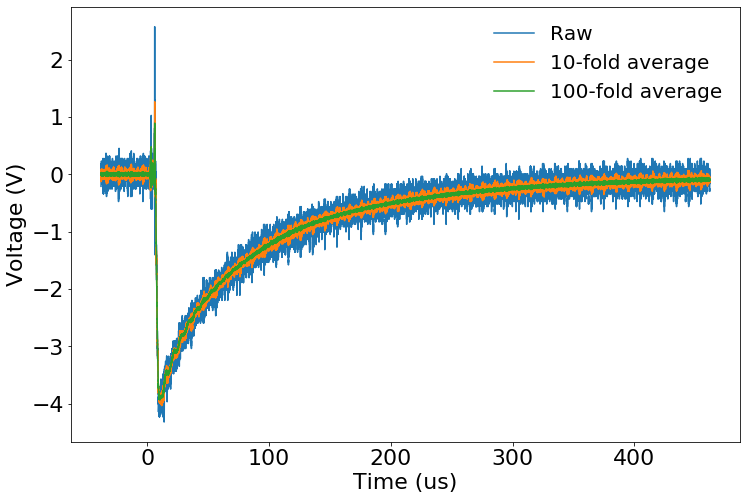

In [146]:
# This test was to make sure that the reshape command as working as desired and the 
# correct waveforms were being averaged.. in this case the 10x3 was split into a 2x5x3
# and then the 5 were averaged away
a=np.arange(30).reshape((10, 3))
print(a)
b=np.reshape(a,(2,5,3))
print(b)
averageTest=np.mean(b,axis=1)
print(averageTest)

#The following line takes the 1000 by 100002 array (why are there 100,002 samples per wave?)
#and transforms the 1000 into 10x100 and then averages over the 100
catAvBy100=np.mean(np.reshape(cathodeList, (10, 100,100002)),axis=1)
catAvBy10=np.mean(np.reshape(cathodeList, (100, 10,100002)),axis=1)
anAvBy100=np.mean(np.reshape(anodeList, (10, 100,100002)),axis=1)
anAvBy10=np.mean(np.reshape(anodeList, (100, 10,100002)),axis=1)


#Plot the waveforms for sanity checking
#as expected averaging waveforms reduces the noise
fig, ax = plt.subplots()
ax.plot(timeList,cathodeList[0],label="Raw")
ax.plot(timeList,catAvBy10[0],label="10-fold average")
ax.plot(timeList,catAvBy100[0],label="100-fold average")
ax.set_xlabel('Time (us)')
ax.set_ylabel('Voltage (V)')
ax.legend(fontsize=20,loc='upper right')
#ax.plot(timeList,catAvBy100[9])

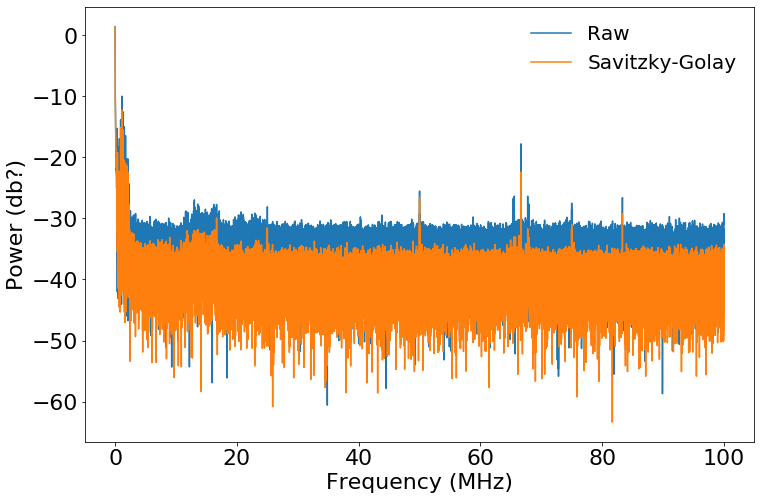

In [47]:
#Convert to dB... relative to 1.0
def convertTodB(cVals):
    N=len(cVals)
    return 10*np.log10(2.0/N * np.abs(cVals[:N//2]))

#Now we are going to look at some frequency domain stuff
N=len(cathodeList[0])
#print(int(N/2))

#First take the FFT of the voltage values
catf = scipy.fftpack.fft(cathodeList[0])
#print(catf[100])
#print(np.shape(catf))
catfSmooth = scipy.fftpack.fft(smoothCat[0])

#Next define the frequency values for the x-axis
dt=h_scale
xf = np.linspace(0.0, 1e-6/(2.0*dt), int(N/2))
fig, ax = plt.subplots()

ax.plot(xf,convertTodB(catf),label="Raw")
ax.plot(xf,convertTodB(catfSmooth),label="Savitzky-Golay")
ax.set_xlabel('Frequency (MHz)')
_ = ax.set_ylabel('Power (db?)')
ax.legend(fontsize=20,loc='upper right')
#ax.set_yscale('log')


In [4]:
from scipy.signal import butter,filtfilt

#Wrapper for a lowpass butterworth filter
def butter_lowpass_filter(data, cutoff, fs, order):
    # Filter requirements.
    #T = 5.0         # Sample Period
    #fs = 30.0       # sample rate, Hz
    #cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    #order = 2       # sin wave can be approx represented as quadratic
    #n = int(T * fs) # total number of samples
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y



In [110]:
fs=1./h_scale
#Run some low pass filters with different cutoff values
catLow =butter_lowpass_filter(cathodeList[0],1e7,fs,2)
catLow1e6 =butter_lowpass_filter(cathodeList[0],1e6,fs,2)
catLow5e5 =butter_lowpass_filter(cathodeList[0],5e5,fs,2)
anLow =butter_lowpass_filter(anodeList[0],1e7,fs,2)
anLow1e6 =butter_lowpass_filter(anodeList[0],1e6,fs,2)
anLow5e5 =butter_lowpass_filter(anodeList[0],5e5,fs,2)
 
    

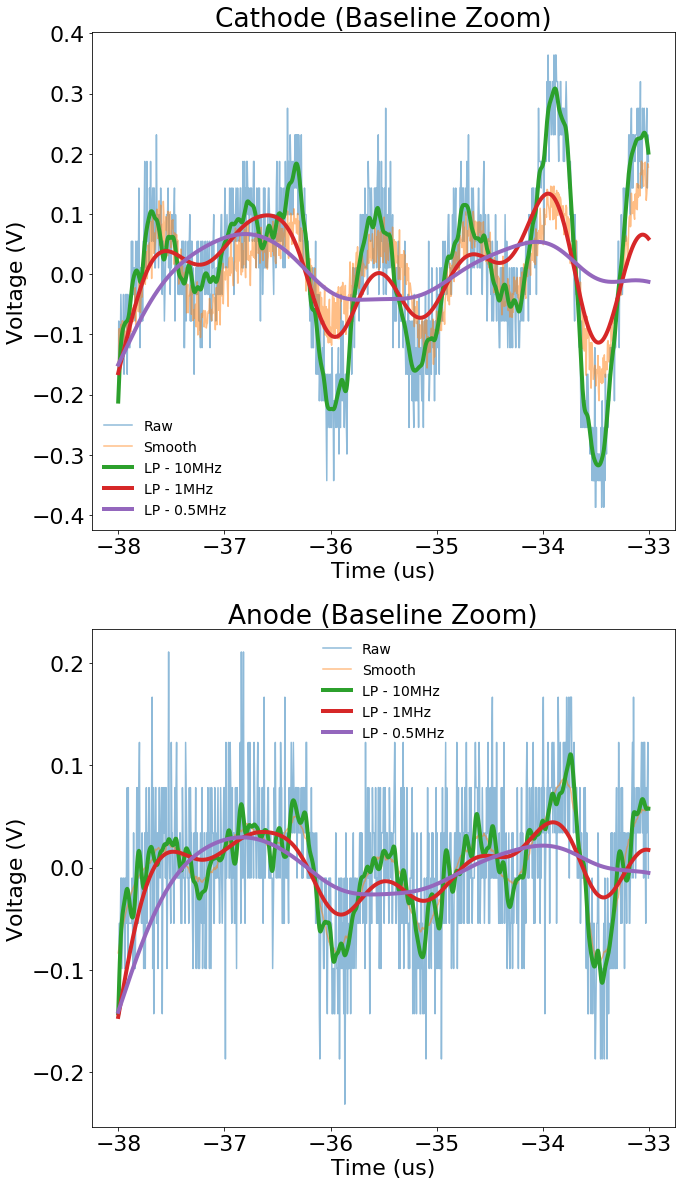

In [115]:
fig, ax = plt.subplots(2,1)
ax[0].plot(timeList[0:1000],cathodeList[0][0:1000],label="Raw",alpha=0.5)
ax[0].plot(timeList[0:1000],smoothCat[0][0:1000],label="Smooth",alpha=0.5)
ax[0].plot(timeList[0:1000],catLow[0:1000],label="LP - 10MHz",linewidth=4)
ax[0].plot(timeList[0:1000],catLow1e6[0:1000],label="LP - 1MHz",linewidth=4)
ax[0].plot(timeList[0:1000],catLow5e5[0:1000],label="LP - 0.5MHz",linewidth=4)
ax[0].set_xlabel('Time (us)')
ax[0].set_ylabel('Voltage (V)')
ax[0].set_title("Cathode (Baseline Zoom)")
ax[0].legend(fontsize=14)
ax[1].plot(timeList[0:1000],anodeList[0][0:1000],label="Raw",alpha=0.5)
ax[1].plot(timeList[0:1000],smoothAn[0:1000],label="Smooth",alpha=0.5)
ax[1].plot(timeList[0:1000],anLow[0:1000],label="LP - 10MHz",linewidth=4)
ax[1].plot(timeList[0:1000],anLow1e6[0:1000],label="LP - 1MHz",linewidth=4)
ax[1].plot(timeList[0:1000],anLow5e5[0:1000],label="LP - 0.5MHz",linewidth=4)
ax[1].set_xlabel('Time (us)')
ax[1].set_ylabel('Voltage (V)')
ax[1].set_title("Anode (Baseline Zoom)")
ax[1].legend(fontsize=14)
plt.subplots_adjust(bottom=0.1, right=0.8, top=2)


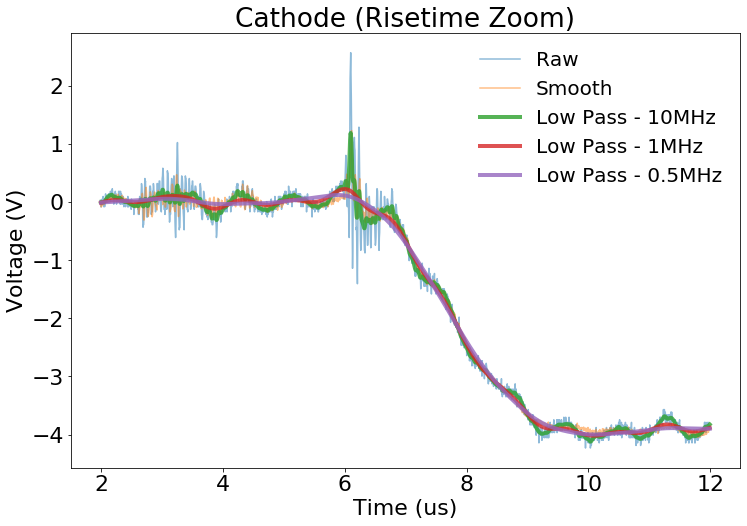

In [60]:
fig, ax = plt.subplots()
ax.plot(timeList[8000:10000],cathodeList[0][8000:10000],label="Raw",alpha=0.5)
ax.plot(timeList[8000:10000],smoothCat[0][8000:10000],label="Smooth",alpha=0.5)
ax.plot(timeList[8000:10000],catLow[8000:10000],label="Low Pass - 10MHz",linewidth=4,alpha=0.8)
ax.plot(timeList[8000:10000],catLow1e6[8000:10000],label="Low Pass - 1MHz",linewidth=4,alpha=0.8)
ax.plot(timeList[8000:10000],catLow5e5[8000:10000],label="Low Pass - 0.5MHz",linewidth=4,alpha=0.8)
ax.set_xlabel('Time (us)')
ax.set_ylabel('Voltage (V)')
ax.set_title("Cathode (Risetime Zoom)")
ax.legend(fontsize=20)

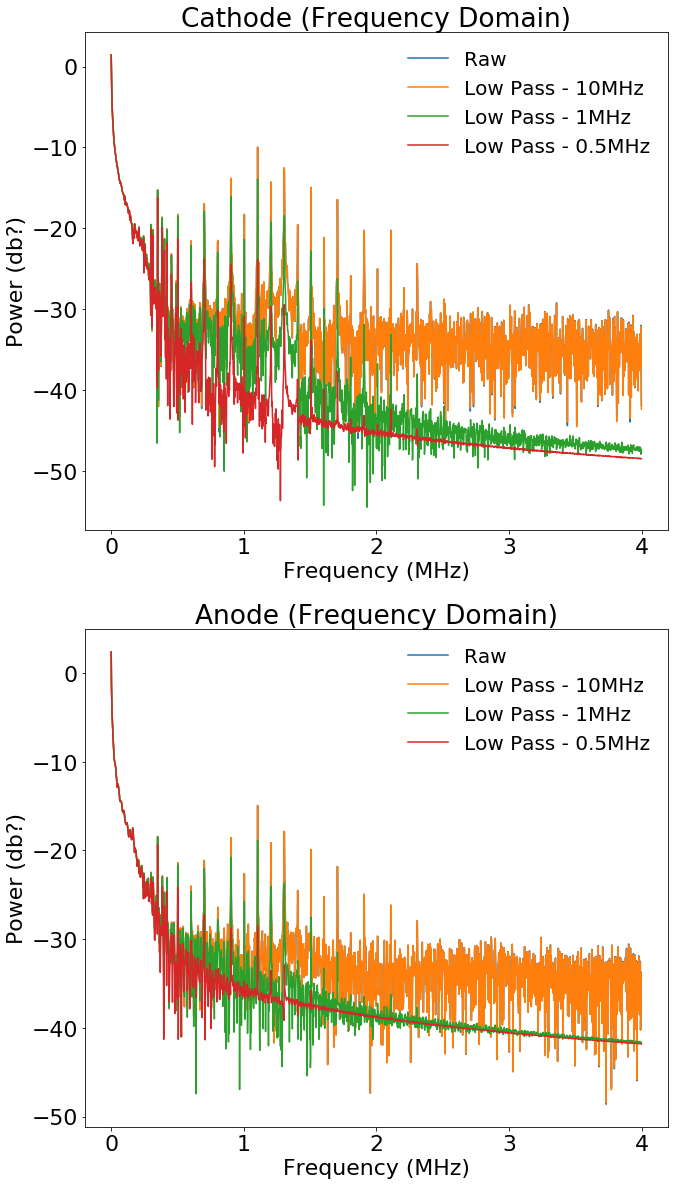

In [132]:
N=len(cathodeList[0])
#print(int(N/2))
dt=h_scale
xf = np.linspace(0.0, 1.0/(2.0*dt), int(N/2))
xf/=1e6 #Converts Hz -->MHz
catf = scipy.fftpack.fft(cathodeList[0])
catfLow = scipy.fftpack.fft(catLow)
catfLow1e6 = scipy.fftpack.fft(catLow1e6)
catfLow5e5 = scipy.fftpack.fft(catLow5e5)
catPwr=convertTodB(catf)
catPwrLow=convertTodB(catfLow)
catPwrLow1e6=convertTodB(catfLow1e6)
catPwrLow5e5=convertTodB(catfLow5e5)
anf = scipy.fftpack.fft(anodeList[0])
anfLow = scipy.fftpack.fft(anLow)
anfLow1e6 = scipy.fftpack.fft(anLow1e6)
anfLow5e5 = scipy.fftpack.fft(anLow5e5)
anPwr=convertTodB(anf)
anPwrLow=convertTodB(anfLow)
anPwrLow1e6=convertTodB(anfLow1e6)
anPwrLow5e5=convertTodB(anfLow5e5)

fig, ax = plt.subplots(2,1)
ax[0].plot(xf[0:2000],catPwr[0:2000],label="Raw")
ax[0].plot(xf[0:2000],catPwrLow[0:2000],label="Low Pass - 10MHz")
ax[0].plot(xf[0:2000],catPwrLow1e6[0:2000],label="Low Pass - 1MHz")
ax[0].plot(xf[0:2000],catPwrLow5e5[0:2000],label="Low Pass - 0.5MHz")
ax[0].set_xlabel('Frequency (MHz)')
ax[0].set_ylabel('Power (db?)')
ax[0].set_title("Cathode (Frequency Domain)")
ax[0].legend(fontsize=20)
ax[1].plot(xf[0:2000],anPwr[0:2000],label="Raw")
ax[1].plot(xf[0:2000],anPwrLow[0:2000],label="Low Pass - 10MHz")
ax[1].plot(xf[0:2000],anPwrLow1e6[0:2000],label="Low Pass - 1MHz")
ax[1].plot(xf[0:2000],anPwrLow5e5[0:2000],label="Low Pass - 0.5MHz")
ax[1].set_xlabel('Frequency (MHz)')
ax[1].set_ylabel('Power (db?)')
ax[1].set_title("Anode (Frequency Domain)")
ax[1].legend(fontsize=20)
plt.subplots_adjust(bottom=0.1, right=0.8, top=2)


Text(0.5, 1.0, 'Cathode + Anode (Noise Forest)')

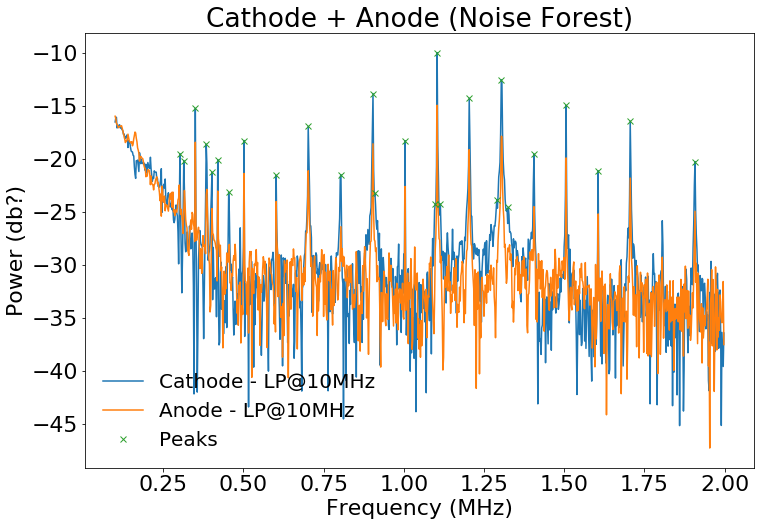

In [134]:
from scipy.signal import find_peaks
peakLocs,_=find_peaks(catPwr,distance=3,height=-25)
fig, ax = plt.subplots()
ax.plot(xf[50:1000],catPwrLow[50:1000],label="Cathode - LP@10MHz")
ax.plot(xf[50:1000],anPwrLow[50:1000],label="Anode - LP@10MHz")
ax.plot(xf[peakLocs][25:51],catPwrLow[peakLocs][25:51],"x",label="Peaks")
filtLocs=peakLocs[25:51]*(xf[1]-xf[0])*1e6
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Power (db?)')
_ = ax.legend(fontsize=20,loc='lower left')
ax.set_title("Cathode + Anode (Noise Forest)")




In [10]:
from scipy.signal import iirnotch,convolve

#Crazy code to repeatedly apply notch filters
#Who knows what optimum values of Q are
def getMultipleNotch(f0List,Q,fs,data):
  #  bList=[]
  #  aList=[]
    y=data
    for f0 in f0List:
        b,a =iirnotch(f0,Q,fs)
        y = filtfilt(b, a, y)
    return y

    
#f0List=[0.1e6,0.2e6,0.3e6,0.4e6,0.5e6,0.6e6,0.7e6,0.8e6,0.9e6,1.0e6,1.1e6,1.2e6,1.3e6,1.4e6,1.5]#,0.9e6,1e6]
#f0List=np.linspace(0.1e6,2.0e6, num=20)
Q=25
#b,a = getMultipleNotch(f0List,Q,fs)

#b1, a1 = iirnotch(f0, Q, fs)
#b2, a2 = iirnotch(0.9e6, Q, fs)
#b = np.convolve(b1,b2)
#a=np.convolve(a1,a2)

#yNotch = filtfilt(b, a, cathodeList[0])
yNotch = getMultipleNotch(filtLocs,Q,fs,cathodeList[0])
catfNotch = scipy.fftpack.fft(yNotch)
catPwrNotch=convertTodB(catfNotch)#10*np.log10(2.0/N * np.abs(catfNotch[:N//2]))


catLowNotch =butter_lowpass_filter(yNotch,0.1e7,fs,2)
catfLowNotch = scipy.fftpack.fft(catLowNotch)
catPwrLowNotch=convertTodB(catfLowNotch)#10*np.log10(2.0/N * np.abs(catfLowNotch[:N//2]))



Text(0.5, 1.0, 'Cathode (Noise Forest)')

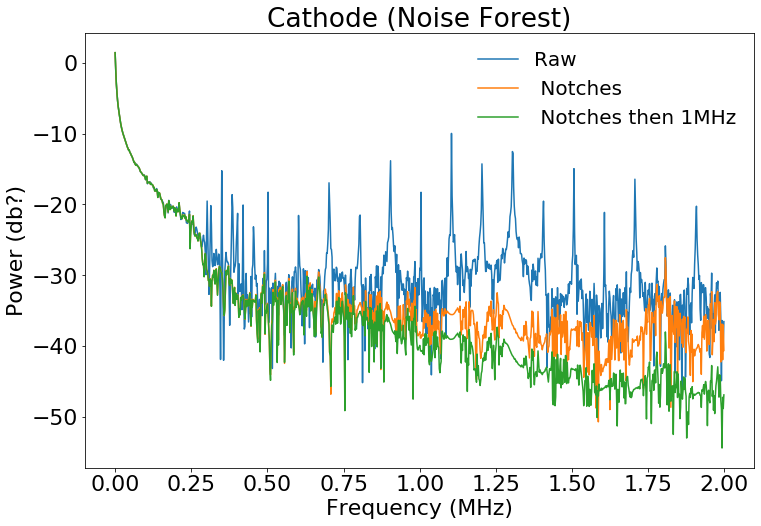

In [66]:

fig, ax = plt.subplots()
ax.plot(xf[0:1000],catPwr[0:1000],label="Raw")
ax.plot(xf[0:1000],catPwrNotch[0:1000],label=" Notches")
ax.plot(xf[0:1000],catPwrLowNotch[0:1000],label=" Notches then 1MHz")
#ax.plot(xf[peakLocs][0:20],catPwrLow[peakLocs][0:20],"x")
#ax.set_yscale('log')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Power (db?)')
_ = ax.legend(fontsize=20)
ax.set_title("Cathode (Noise Forest)")




Text(0.5, 1.0, 'Cathode (Baseline Zoom)')

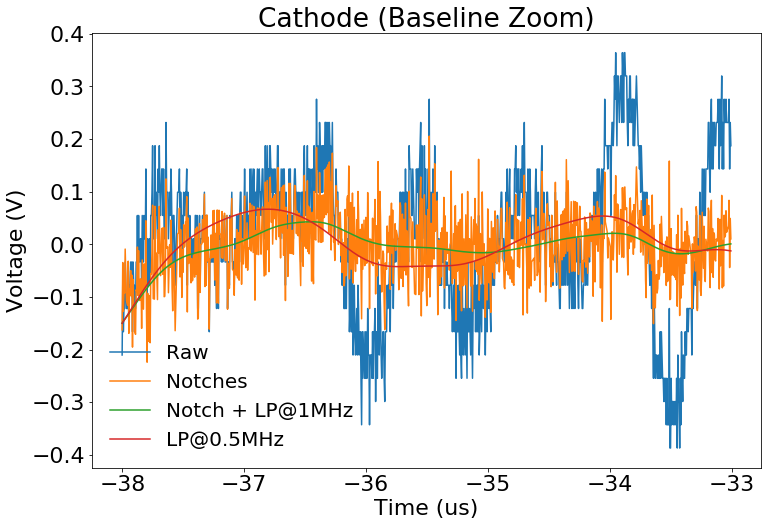

In [67]:
fig, ax = plt.subplots()
ax.plot(timeList[0:1000],cathodeList[0][0:1000],label="Raw")
ax.plot(timeList[0:1000],yNotch[0:1000],label="Notches")
ax.plot(timeList[0:1000],catLowNotch[0:1000],label="Notch + LP@1MHz")
ax.plot(timeList[0:1000],catLow5e5[0:1000],label="LP@0.5MHz")
ax.set_xlabel('Time (us)')
ax.set_ylabel('Voltage (V)')
_ = ax.legend(fontsize=20)
ax.set_title("Cathode (Baseline Zoom)")

Text(0.5, 1.0, 'Cathode (Peak Zoom)')

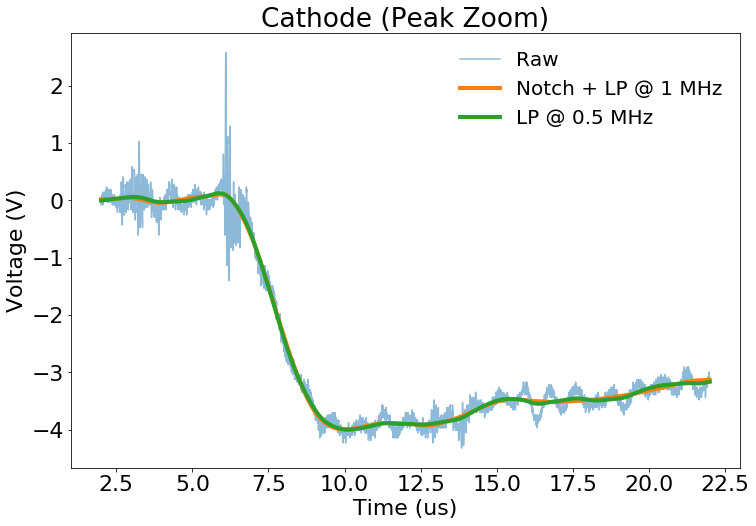

In [72]:
fig, ax = plt.subplots()
ax.plot(timeList[8000:12000],cathodeList[0][8000:12000],label="Raw",alpha=0.5)
#ax.plot(timeList,yNotch)
#ax.plot(timeList,catLow1e6)
#ax.plot(timeList[8000:12000],smoothCat[0][8000:12000],label="SG Smooth")
ax.plot(timeList[8000:12000],catLowNotch[8000:12000],label="Notch + LP @ 1 MHz",linewidth=4)
ax.plot(timeList[8000:12000],catLow5e5[8000:12000],label="LP @ 0.5 MHz",linewidth=4)
#ax.plot(timeList[0:8000],smoothCat[0:8000])
ax.set_xlabel('Time (us)')
ax.set_ylabel('Voltage (V)')
_ = ax.legend(fontsize=20)
ax.set_title("Cathode (Peak Zoom)")


In [73]:
import time
startTime = time.process_time()
minVolt=[]
minTime=[]

#In this loop we loop through all 1000 waveforms an do some SG smoothing 
for cat in cathodeList:
    sc=savgol_filter(cat, 101, 3) # window size 51, polynomial order 3
    result = np.where(sc == np.amin(sc))
    baseline=np.mean(sc[1000:8000])
    minV=sc[result[0][0]]-baseline
    minT=timeList[result[0][0]]
    minVolt.append(minV)
    minTime.append(minT)
endTime = time.process_time()
print(endTime-startTime)

50.19055199999997


Text(0.5, 1.0, 'Cathode Peak (Smoothed by SG)')

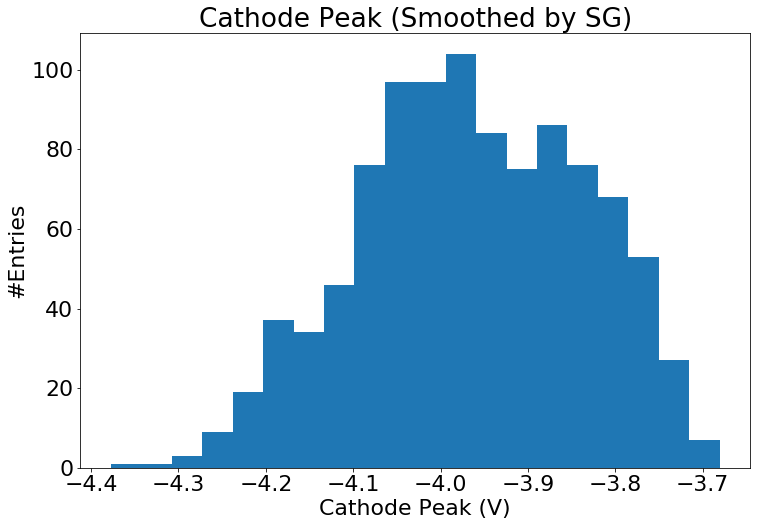

In [76]:
fig, ax = plt.subplots()
ax.hist(minVolt,bins=20)
ax.set_xlabel('Cathode Peak (V)')
ax.set_ylabel('#Entries')
ax.set_title("Cathode Peak (Smoothed by SG)")

Text(0.5, 1.0, 'Cathode Peak (Smoothed by SG)')

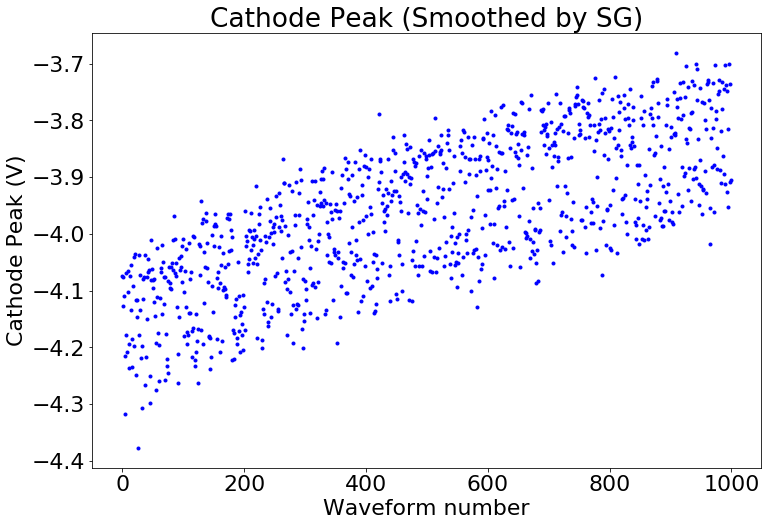

In [77]:
fig, ax = plt.subplots()
waveNum=np.arange(len(minVolt))
ax.plot(waveNum,minVolt,"b.")
ax.set_ylabel('Cathode Peak (V)')
ax.set_xlabel('Waveform number')
ax.set_title("Cathode Peak (Smoothed by SG)")

(1000, 50001)
(50001,)
pwrLowTot[0]: 65825.35019950008
pwrLowList[0]: [6.92997916e+04 3.90746807e+04 2.52593814e+04 ... 4.41499857e-02
 4.41499856e-02 4.41499856e-02]
pwr[0]: 1.4218669292896546
Time taken: 98.62790999999999


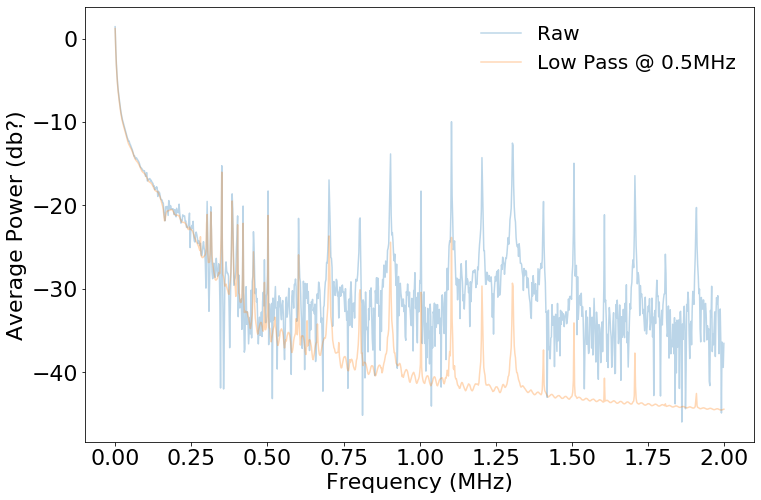

In [80]:
import time

startTime = time.process_time()
fminVolt=[]
fminTime=[]
catPwrLowList=[]
lowList=[]
notchList=[]
fig, ax = plt.subplots()
count=0

#Now loop through all waveforms and apply the low pass filter
for cat in cathodeList:
    sc =butter_lowpass_filter(cat,0.5e6,fs,2)
    lowList.append(sc)
    baseline=np.mean(sc[1000:8000])
    sc-=baseline
    result = np.where(sc == np.amin(sc))
    minV=sc[result[0][0]]
    minT=timeList[result[0][0]]
    fminVolt.append(minV)
    fminTime.append(minT)
    
    yn = getMultipleNotch(filtLocs,Q,fs,cat)
    yln =butter_lowpass_filter(yn,0.1e7,fs,2)
    baseline=np.mean(yln[1000:8000])
    yln-=baseline
    notchList.append(yln)
    
    count+=1
    
    catfLow = scipy.fftpack.fft(sc)
    catPwrLow=np.abs(catfLow[:N//2])
    catPwrLowList.append(catPwrLow)
    if count == 1:
        catfLowTot=catfLow
    else:
        catfLowTot+=catfLow
    #ax.plot(timeList, smoothCat, alpha=0.5)
    #ax.plot(xf[0:1000],catPwrLow[0:1000],alpha=0.3)
    #if count > 10:
    #    break
lowList=np.vstack(lowList)
notchList=np.vstack(notchList)
catPwrLowList=np.vstack(catPwrLowList)
#print(np.shape(catPwrLowList))
catfLowTot/=count
catPwrLowTot=np.mean(catPwrLowList,axis=0)
realcatPwrLowList=10*np.log10(2.0/N *catPwrLowList)
#print(np.shape(catPwrLowTot))
#print("catPwrLowTot[0]: "+str(catPwrLowTot[0]))
#print("catPwrLowList[0]: "+str(catPwrLowList[0]))
#print("catPwr[0]: "+str(catPwr[0]))
ax.plot(xf[0:1000],catPwr[0:1000],alpha=0.3,label="Raw")
ax.plot(xf[0:1000],10*np.log10(2.0/N *catPwrLowTot[0:1000]),alpha=0.3,label="Low Pass @ 0.5MHz")
endTime = time.process_time()
#ax.set_yscale('log')
print("Time taken: "+str(endTime-startTime))
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Average Power (db?)')
_ = ax.legend(fontsize=20)

Text(0, 0.5, '#Entries')

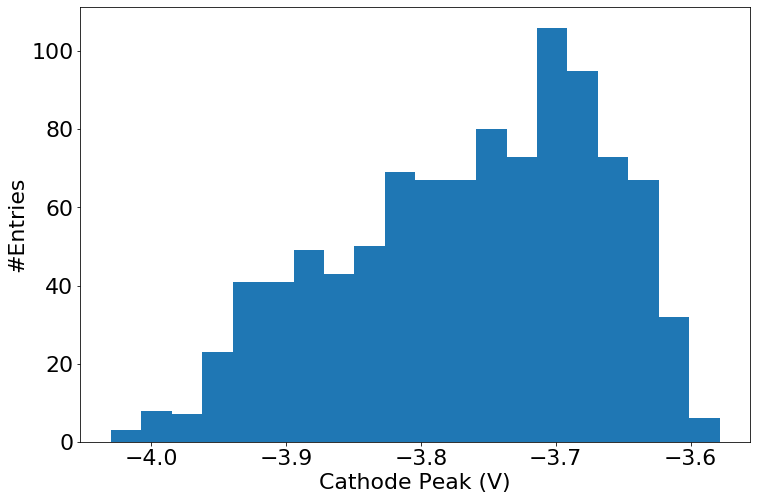

In [81]:
fig, ax = plt.subplots()
ax.hist(fminVolt,bins=20)
ax.set_xlabel('Cathode Peak (V)')
ax.set_ylabel('#Entries')

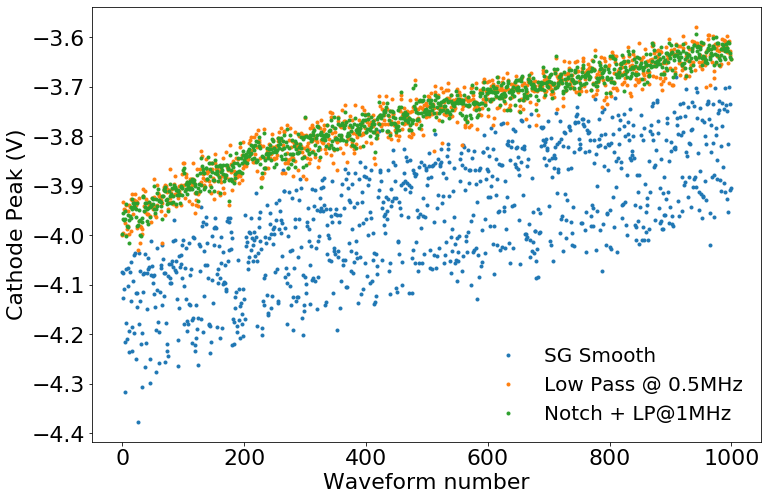

In [144]:
fig, ax = plt.subplots()
minNotch = np.amin(notchList, axis=1)
minLow = np.amin(lowList, axis=1)
waveNum=np.arange(len(minVolt))
ax.plot(waveNum,minVolt,'.',label="SG Smooth")
ax.plot(waveNum,minLow,'.',label="Low Pass @ 0.5MHz")
ax.plot(waveNum,minNotch,'.',label="Notch + LP@1MHz")
ax.set_ylabel('Cathode Peak (V)')
ax.set_xlabel('Waveform number')
_ = ax.legend(fontsize=20)

In [86]:
# make these smaller to increase the resolution
specList=np.transpose(realcatPwrLowList)
#print(np.shape(specList))
#print(dt)
dx, dy = 1, 1.0/(2.0*dt*len(cathodeList[0]))
#print(dy)
dy/=1e6 #Convert to MHz

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(0, 1001*dy, dy),
                slice(1, 1000 + dx, dx)]

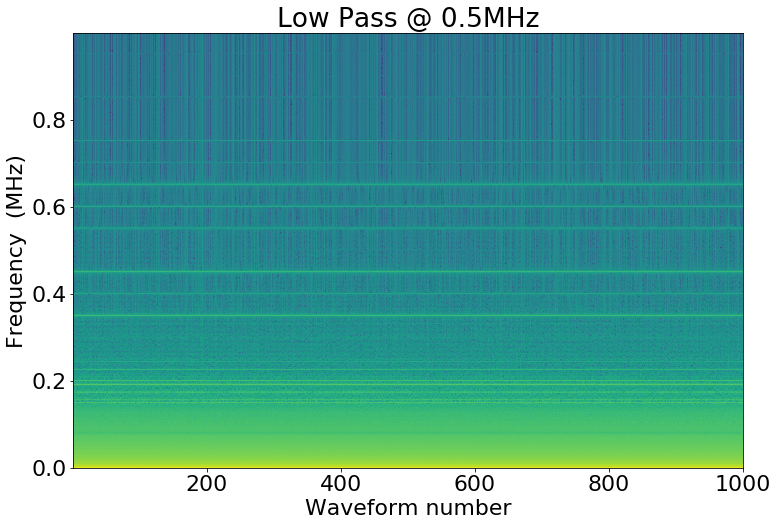

In [87]:
fig, ax = plt.subplots()
ax.pcolormesh(x,y,specList[:][0:1001])
ax.set_title('Low Pass @ 0.5MHz')
ax.set_ylabel('Frequency  (MHz)')
_ = ax.set_xlabel('Waveform number')

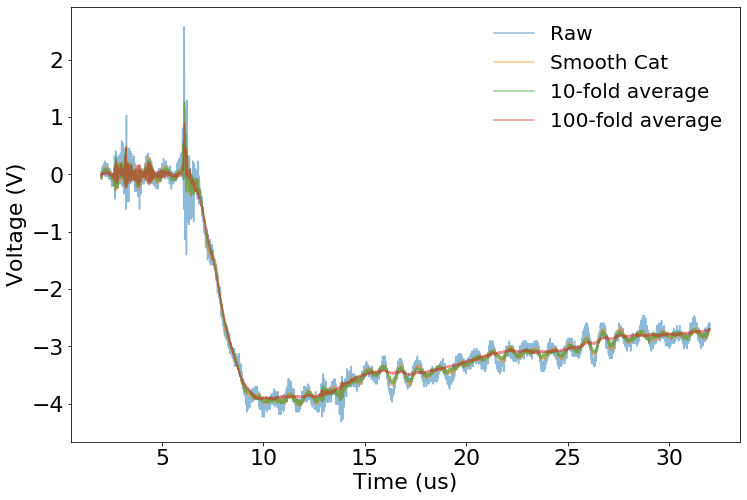

In [89]:
fig, ax = plt.subplots()
ax.plot(timeList[8000:14000],cathodeList[0][8000:14000],label="Raw",alpha=0.5)
#ax.plot(timeList[8000:12000],cathodeList[2][8000:12000])
#ax.plot(timeList,yNotch)
#ax.plot(timeList,catLowNotch)
#ax.plot(timeList,catLow1e6)
#ax.plot(timeList[8000:12000],catLow5e5[8000:12000])
ax.plot(timeList[8000:14000],smoothCat[0][8000:14000],label="Smooth Cat",alpha=0.5)
ax.plot(timeList[8000:14000],catAvBy10[0][8000:14000],label="10-fold average",alpha=0.5)
ax.plot(timeList[8000:14000],catAvBy100[0][8000:14000],label="100-fold average",alpha=0.5)
ax.set_xlabel('Time (us)')
ax.set_ylabel('Voltage (V)')
_ = ax.legend(fontsize=20)



Text(0.5, 1.0, 'Raw')

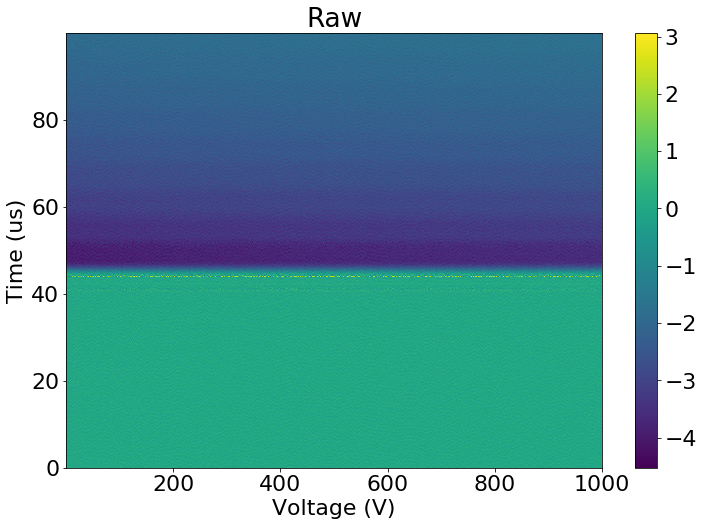

In [23]:
dx, dy = 1, dt*1e6

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(0, 20001*dy, dy),
                slice(1, 1000 + dx, dx)]
waveList=np.transpose(cathodeList)
fig, ax = plt.subplots()
#print(np.shape(cathodeList))
im=ax.pcolormesh(x,y,waveList[:][0:20001])
cb = fig.colorbar(im)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Time (us)')
ax.set_title('Raw')

Text(0.5, 1.0, 'Raw (Baseline Zoom)')

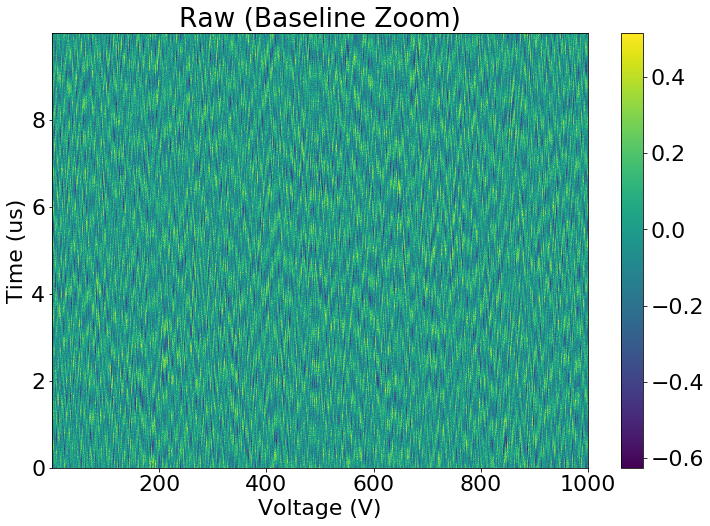

In [90]:
dx, dy = 1, dt*1e6

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(0, 2001*dy, dy),
                slice(1, 1000 + dx, dx)]
waveList=np.transpose(cathodeList)
fig, ax = plt.subplots()
#print(np.shape(cathodeList))
im=ax.pcolormesh(x,y,waveList[:][0:2001])
cb = fig.colorbar(im)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Time (us)')
ax.set_title('Raw (Baseline Zoom)')

100


Text(0.5, 1.0, '10-fold Average')

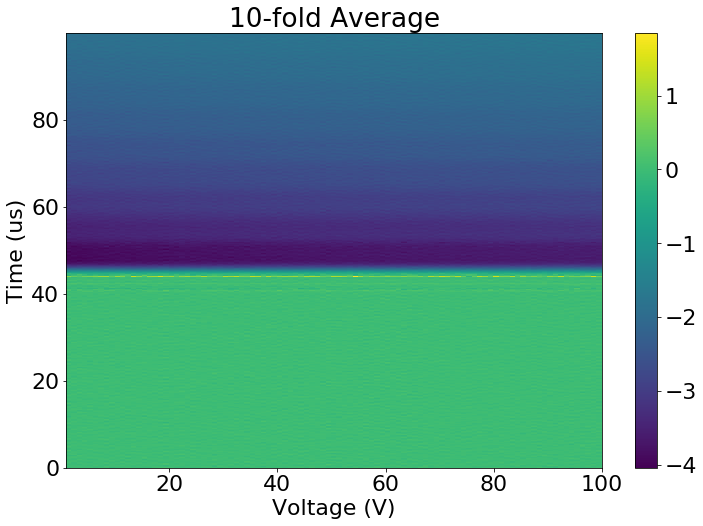

In [25]:
dx, dy = 1, dt*1e6
print(len(catAvBy10))
# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(0, 20001*dy, dy),
                slice(1, 100 + dx, dx)]
waveList=np.transpose(catAvBy10)
fig, ax = plt.subplots()
#print(np.shape(cathodeList))
im=ax.pcolormesh(x,y,waveList[:][0:20001])
cb = fig.colorbar(im)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Time (us)')
ax.set_title('10-fold Average')

100


Text(0.5, 1.0, '10-fold Average (baseline zoom)')

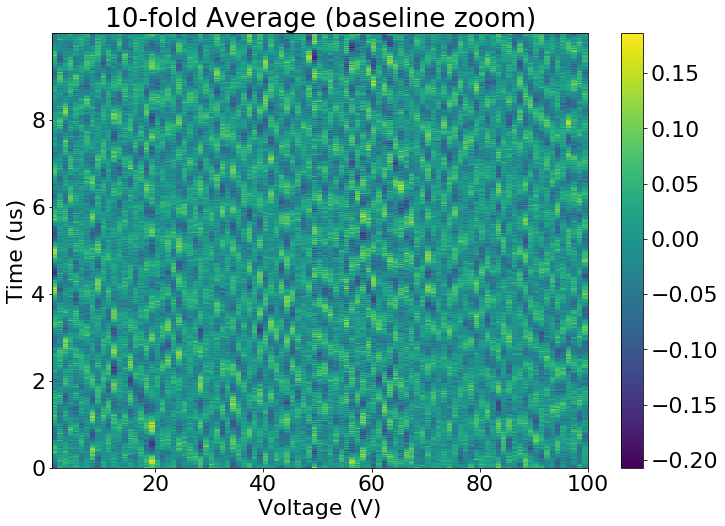

In [91]:
dx, dy = 1, dt*1e6
print(len(catAvBy10))
# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(0, 2001*dy, dy),
                slice(1, 100 + dx, dx)]
waveList=np.transpose(catAvBy10)
fig, ax = plt.subplots()
#print(np.shape(cathodeList))
im=ax.pcolormesh(x,y,waveList[:][0:2001])
cb = fig.colorbar(im)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Time (us)')
ax.set_title('10-fold Average (baseline zoom)')

Text(0.5, 1.0, 'Low Pass @ 0.5MHz')

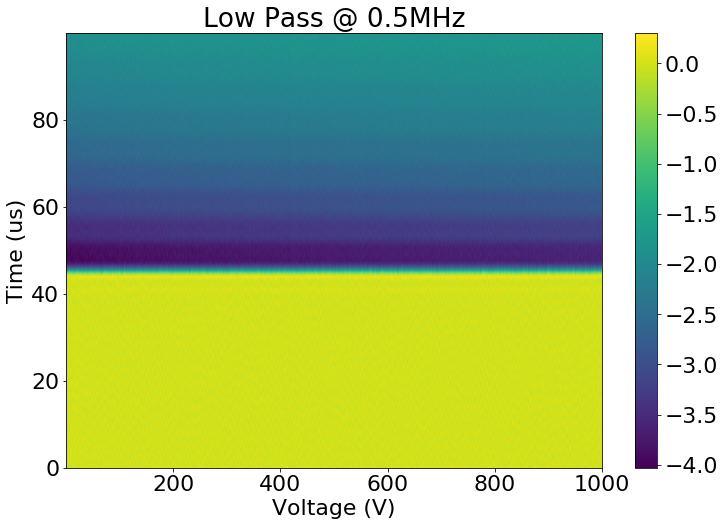

In [27]:
dx, dy = 1, dt*1e6

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(0, 20001*dy, dy),
                slice(1, 1000 + dx, dx)]
waveList=np.transpose(lowList)
fig, ax = plt.subplots()
#print(np.shape(cathodeList))
im=ax.pcolormesh(x,y,waveList[:][0:20001])
cb = fig.colorbar(im)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Time (us)')
ax.set_title('Low Pass @ 0.5MHz')

Text(0.5, 1.0, 'Low Pass @ 0.5MHz (baseline zoom)')

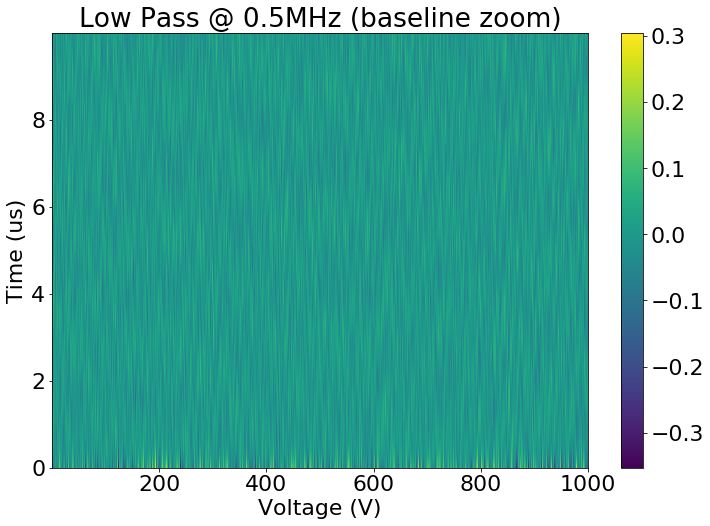

In [92]:
dx, dy = 1, dt*1e6

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(0, 2001*dy, dy),
                slice(1, 1000 + dx, dx)]
waveList=np.transpose(lowList)
fig, ax = plt.subplots()
#ax.set_ylim(0.000001,0.000010)
#print(np.shape(cathodeList))
im=ax.pcolormesh(x,y,waveList[:][0:2001])
cb = fig.colorbar(im)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Time (us)')
ax.set_title('Low Pass @ 0.5MHz (baseline zoom)')

Text(0.5, 1.0, 'Notch + LP@1MHz')

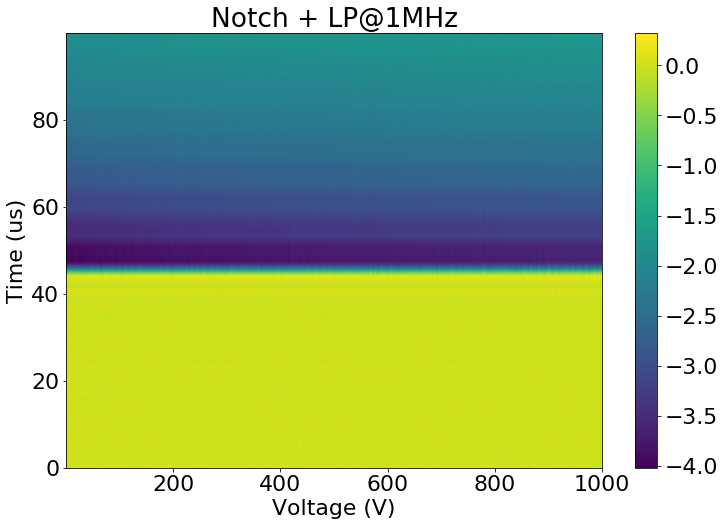

In [93]:
dx, dy = 1, dt*1e6

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(0, 20001*dy, dy),
                slice(1, 1000 + dx, dx)]
waveList=np.transpose(notchList)
fig, ax = plt.subplots()
#print(np.shape(cathodeList))
im=ax.pcolormesh(x,y,waveList[:][0:20001])
cb = fig.colorbar(im)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Time (us)')
ax.set_title('Notch + LP@1MHz')

Text(0.5, 1.0, 'Notch + LP@1MHz (baseline zoom)')

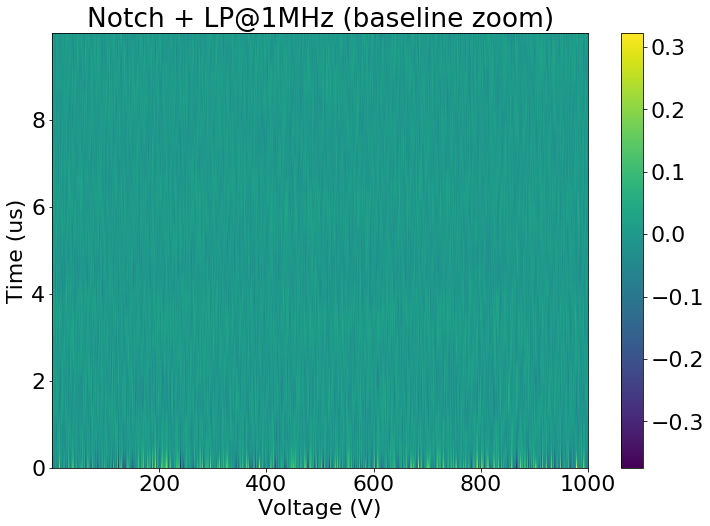

In [94]:
dx, dy = 1, dt*1e6

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(0, 2001*dy, dy),
                slice(1, 1000 + dx, dx)]
waveList=np.transpose(notchList)
fig, ax = plt.subplots()
#print(np.shape(cathodeList))
im=ax.pcolormesh(x,y,waveList[:][0:2001])
cb = fig.colorbar(im)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Time (us)')
ax.set_title('Notch + LP@1MHz (baseline zoom)')

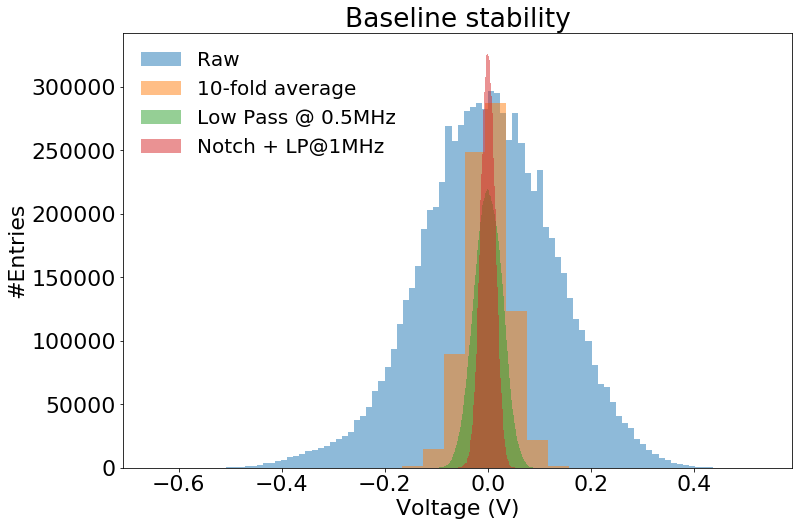

In [98]:
fig, ax = plt.subplots()
arRaw=np.transpose(np.array(cathodeList))[100:8000]
flatRaw=np.array(arRaw).flatten()
_ = ax.hist(flatRaw,bins=100,label="Raw",alpha=0.5)
arAverage=np.transpose(np.array(catAvBy10))[100:8000]
flatAverage=np.array(arAverage).flatten()
_ = ax.hist(flatAverage,bins=10,label="10-fold average",alpha=0.5)
arLow=np.transpose(np.array(lowList))[100:8000]
flatLow=np.array(arLow).flatten()
_ = ax.hist(flatLow,bins=100,label="Low Pass @ 0.5MHz",alpha=0.5)
arNotch=np.transpose(np.array(notchList))[100:8000]
flatNotch=np.array(arNotch).flatten()
_ = ax.hist(flatNotch,bins=100,label="Notch + LP@1MHz",alpha=0.5)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('#Entries')
ax.set_title("Baseline stability")
_ = ax.legend(fontsize=20)


In [30]:
def downsampleByN(data, N):
    arr=np.array(data[0:100000])
    return np.mean(arr.reshape(-1, N), axis=1)

In [31]:
smoothThen100 = [downsampleByN(data,100) for data in lowList]
time100 = downsampleByN(timeList,100)
smoothThen10 = [downsampleByN(data,10) for data in lowList]
time10 = downsampleByN(timeList,10)

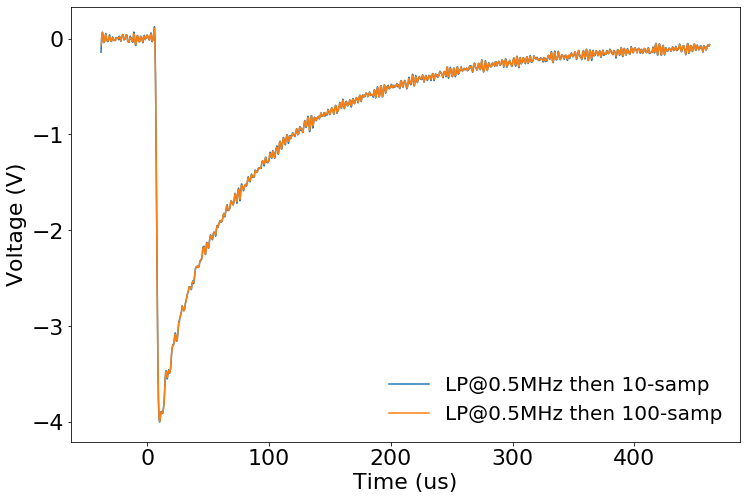

In [99]:
fig, ax = plt.subplots()
ax.plot(time10,smoothThen10[0],label="LP@0.5MHz then 10-samp")
#for i in range(10):
ax.plot(time100,smoothThen100[0],label="LP@0.5MHz then 100-samp")
ax.set_xlabel('Time (us)')
ax.set_ylabel('Voltage (V)')
_ = ax.legend(fontsize=20)

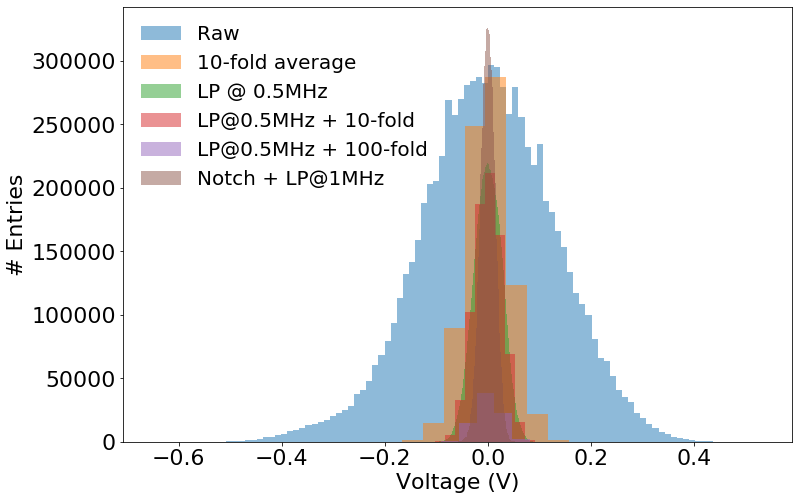

In [101]:
fig, ax = plt.subplots()
arRaw=np.transpose(np.array(cathodeList))[100:8000]
flatRaw=np.array(arRaw).flatten()
_ = ax.hist(flatRaw,bins=100,label="Raw",alpha=0.5)
arAverage=np.transpose(np.array(catAvBy10))[100:8000]
flatAverage=np.array(arAverage).flatten()
_ = ax.hist(flatAverage,bins=10,label="10-fold average",alpha=0.5)
arSmooth=np.transpose(np.array(lowList))[100:8000]
flatSmooth=np.array(arSmooth).flatten()
_ = ax.hist(flatSmooth,bins=100,label="LP @ 0.5MHz",alpha=0.5)
arSmooth10=np.transpose(np.array(smoothThen10))[10:800]
flatSmooth10=np.array(arSmooth10).flatten()
_ = ax.hist(flatSmooth10,bins=10,label="LP@0.5MHz + 10-fold",alpha=0.5)
arSmooth100=np.transpose(np.array(smoothThen100))[1:80]
flatSmooth100=np.array(arSmooth100).flatten()
_ = ax.hist(flatSmooth100,bins=5,label="LP@0.5MHz + 100-fold",alpha=0.5)
arNotch=np.transpose(np.array(notchList))[100:8000]
flatNotch=np.array(arNotch).flatten()
_ = ax.hist(flatNotch,bins=100,label="Notch + LP@1MHz",alpha=0.5)
ax.set_ylabel('# Entries')
ax.set_xlabel('Voltage (V)')
_ = ax.legend(fontsize=20)



In [100]:
print("Std. dev. of samples 100-8000 of raw waveforms is "+str(np.std(flatRaw))+"V")
print("Std. dev. of samples 100-8000 of 10 waveform average is "+str(np.std(flatAverage))+"V")
print("Std. dev. of samples 100-8000 of LP@0.5MHz filter "+str(np.std(flatSmooth))+"V")
print("Std. dev. of samples 100-8000 of notch + LP@1MHz filter "+str(np.std(flatNotch))+"V")
print("Std. dev. of samples 100-8000 of low pass filter + 10 sample average "+str(np.std(flatSmooth10))+"V")
print("Std. dev. of samples 1-80 of low pass filter + 100 sample average "+str(np.std(flatSmooth100))+"V")


Std. dev. of samples 100-8000 of raw waveforms is 0.12940452958142978V
Std. dev. of samples 100-8000 of 10 waveform average is 0.040820063557817254V
Std. dev. of samples 100-8000 of LP@0.5MHz filter 0.026650124778741686V
Std. dev. of samples 100-8000 of notch + LP@1MHz filter 0.014096861086624835V
Std. dev. of samples 100-8000 of low pass filter + 10 sample average 0.026633204248256288V
Std. dev. of samples 1-80 of low pass filter + 100 sample average 0.025072716649036507V


In [150]:
#print(catAvBy10.shape)
#print(cathodeList.shape)
catMinBy10 = np.amin(catAvBy10, axis=1)
catMinBy100 = np.amin(catAvBy100, axis=1)
anMaxBy10 = np.amax(anAvBy10, axis=1)
anMaxBy100 = np.amax(anAvBy100, axis=1)
minRaw = np.amin(cathodeList,axis=1)
waveBy10 = np.linspace(5,995,100)
waveBy100 = np.linspace(50,950,10)
#print(waveBy10)
#print(catMinBy10.shape)

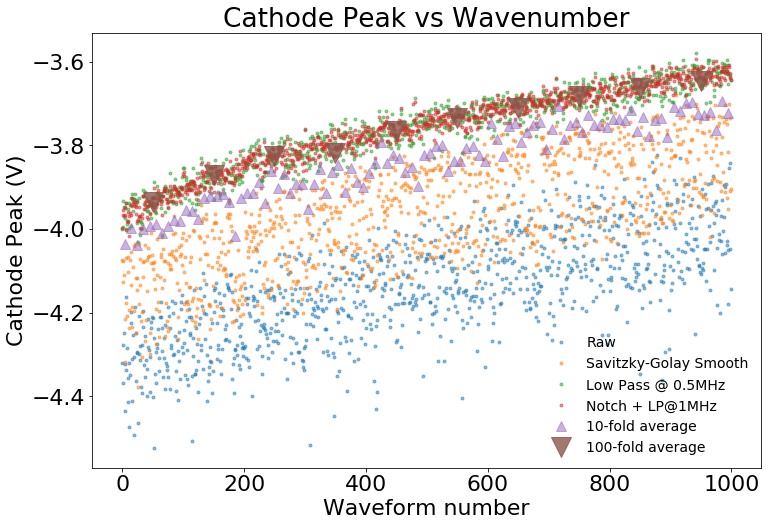

In [148]:
fig, ax = plt.subplots()
ax.plot(waveNum,minRaw,".",label="Raw",alpha=0.5)
ax.plot(waveNum,minVolt,".",label="Savitzky-Golay Smooth",alpha=0.5)
ax.plot(waveNum,fminVolt,".",label="Low Pass @ 0.5MHz",alpha=0.5)
ax.plot(waveNum,minNotch,".",label="Notch + LP@1MHz",alpha=0.5)
ax.plot(waveBy10,catMinBy10,".",label="10-fold average",alpha=0.5,markersize=10,marker="^")
ax.plot(waveBy100,catMinBy100,".",label="100-fold average",alpha=0.8,markersize=20,marker="v")
ax.set_ylabel('Cathode Peak (V)')
ax.set_xlabel('Waveform number')
ax.set_title("Cathode Peak vs Wavenumber")
_ = ax.legend(fontsize=14)

In [163]:
lowAn = [butter_lowpass_filter(an,0.5e6,fs,2) for an in anodeList]
lowAn1e6 = [butter_lowpass_filter(an,1e6,fs,2) for an in anodeList]
lowAn4e5 = [butter_lowpass_filter(an,4e5,fs,2) for an in anodeList]
lowAn3e5 = [butter_lowpass_filter(an,3e5,fs,2) for an in anodeList]
lowAn6e5 = [butter_lowpass_filter(an,6e5,fs,2) for an in anodeList]
#notchAn = [getMultipleNotch(filtLocs,Q,fs,an) for an in anodeList ]
#notchFiltAn = [butter_lowpass_filter(an,1e6,fs,2) for an in notchAn ]
maxRawAn = np.amax(anodeList,axis=1)
maxLowAn = np.amax(lowAn,axis=1)
maxLowAn1e6 = np.amax(lowAn1e6,axis=1)
maxLowAn4e5 = np.amax(lowAn4e5,axis=1)
maxLowAn3e5 = np.amax(lowAn3e5,axis=1)
maxLowAn6e5 = np.amax(lowAn6e5,axis=1)
#maxNotchAn = np.amax(notchAn,axis=1)
#maxNotchFiltAn = np.amax(notchFiltAn,axis=1)

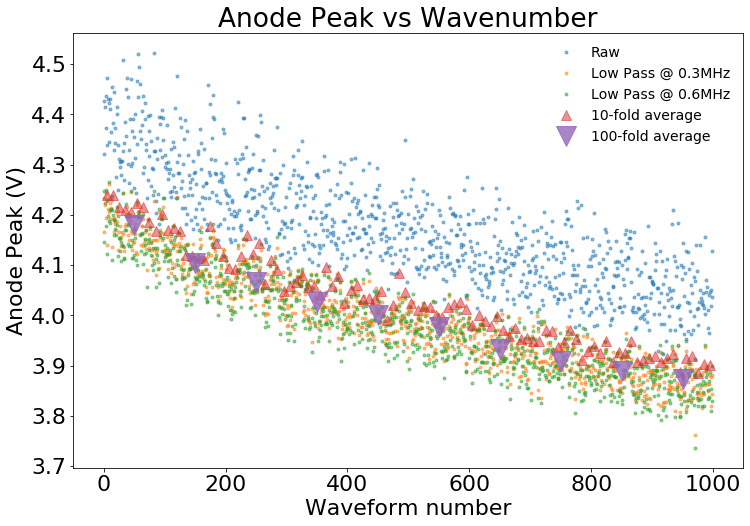

In [167]:
fig, ax = plt.subplots()
ax.plot(waveNum,maxRawAn,".",label="Raw",alpha=0.5)
#ax.plot(waveNum,minVolt,".",label="Savitzky-Golay Smooth",alpha=0.5)
#ax.plot(waveNum,maxLowAn,".",label="Low Pass @ 0.5MHz",alpha=0.5)
#ax.plot(waveNum,maxLowAn1e6,".",label="Low Pass @ 1MHz",alpha=0.5)
ax.plot(waveNum,maxLowAn3e5,".",label="Low Pass @ 0.3MHz",alpha=0.5)
#ax.plot(waveNum,maxLowAn4e5,".",label="Low Pass @ 0.4MHz",alpha=0.5)
ax.plot(waveNum,maxLowAn6e5,".",label="Low Pass @ 0.6MHz",alpha=0.5)
#ax.plot(waveNum,maxNotchAn,".",label="Notch",alpha=0.5)
#ax.plot(waveNum,maxNotchFiltAn,".",label="Notch + LP@1MHz",alpha=0.5)
#ax.plot(waveBy10,catMinBy10,".",label="10-fold average",alpha=0.5,markersize=10,marker="^")
#ax.plot(waveBy100,catMinBy100,".",label="100-fold average",alpha=0.8,markersize=20,marker="v")
ax.plot(waveBy10,anMaxBy10,".",label="10-fold average",alpha=0.5,markersize=10,marker="^")
ax.plot(waveBy100,anMaxBy100,".",label="100-fold average",alpha=0.8,markersize=20,marker="v")
ax.set_ylabel('Anode Peak (V)')
ax.set_xlabel('Waveform number')
ax.set_title("Anode Peak vs Wavenumber")
_ = ax.legend(fontsize=14)

Text(0.5, 1.0, 'Anode (Baseline Zoom)')

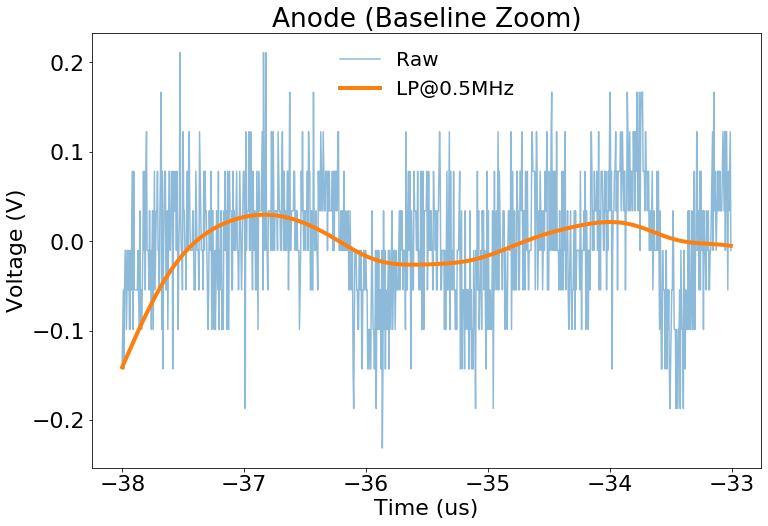

In [161]:
fig, ax = plt.subplots()
ax.plot(timeList[0:1000],anodeList[0][0:1000],label="Raw",alpha=0.5)
#ax.plot(timeList[0:1000],notchFiltAn[0][0:1000],label="Notch + LP@1MHz",linewidth=4)
ax.plot(timeList[0:1000],lowAn[0][0:1000],label="LP@0.5MHz",linewidth=4)
ax.set_xlabel('Time (us)')
ax.set_ylabel('Voltage (V)')
_ = ax.legend(fontsize=20)
ax.set_title("Anode (Baseline Zoom)")

Text(0.5, 1.0, 'Anode (Peak Zoom)')

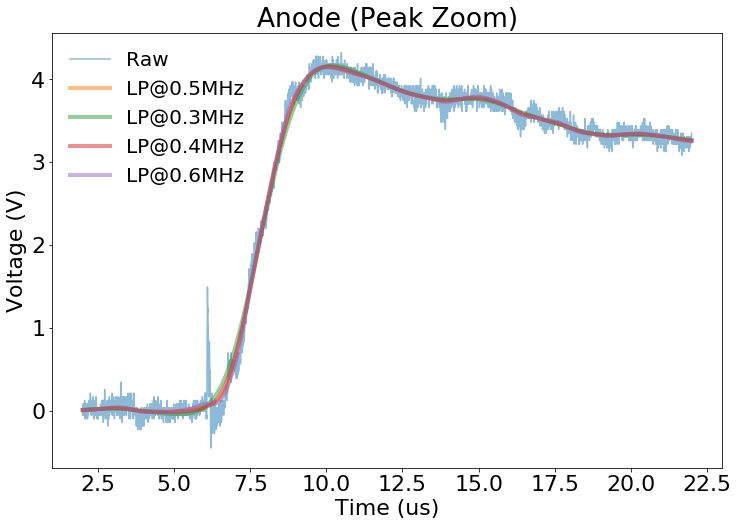

In [166]:
fig, ax = plt.subplots()
ax.plot(timeList[8000:12000],anodeList[0][8000:12000],label="Raw",alpha=0.5)
#ax.plot(timeList[8000:12000],notchFiltAn[0][8000:12000],label="Notch + LP@1MHz",linewidth=4)
ax.plot(timeList[8000:12000],lowAn[0][8000:12000],label="LP@0.5MHz",linewidth=4,alpha=0.5)
ax.plot(timeList[8000:12000],lowAn3e5[0][8000:12000],label="LP@0.3MHz",linewidth=4,alpha=0.5)
ax.plot(timeList[8000:12000],lowAn4e5[0][8000:12000],label="LP@0.4MHz",linewidth=4,alpha=0.5)
ax.plot(timeList[8000:12000],lowAn6e5[0][8000:12000],label="LP@0.6MHz",linewidth=4,alpha=0.5)
ax.set_xlabel('Time (us)')
ax.set_ylabel('Voltage (V)')
_ = ax.legend(fontsize=20)
ax.set_title("Anode (Peak Zoom)")

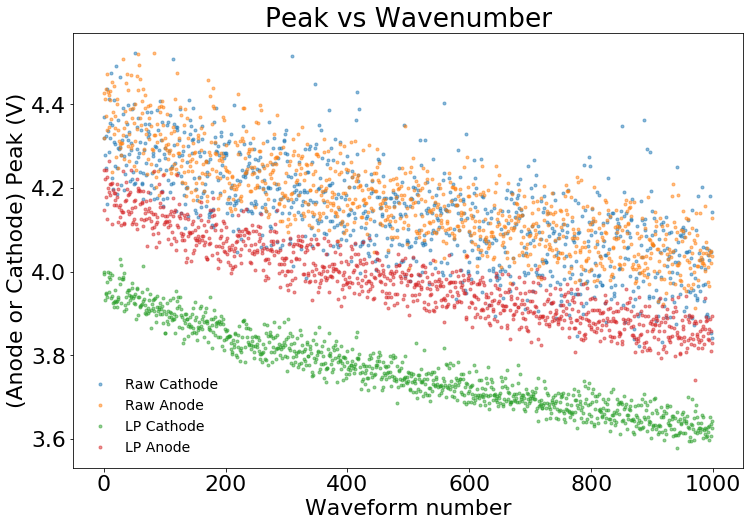

In [145]:
fig, ax = plt.subplots()
ax.plot(waveNum,np.fabs(minRaw),".",label="Raw Cathode",alpha=0.5)
ax.plot(waveNum,maxRawAn,".",label="Raw Anode",alpha=0.5)
#ax.plot(waveNum,minVolt,".",label="Savitzky-Golay Smooth",alpha=0.5)
ax.plot(waveNum,np.fabs(minLow),".",label="LP Cathode",alpha=0.5)
ax.plot(waveNum,maxLowAn,".",label="LP Anode",alpha=0.5)
#ax.plot(waveNum,maxNotchAn,".",label="Notch",alpha=0.5)
#ax.plot(waveNum,maxNotchFiltAn,".",label="Notch + LP@1MHz",alpha=0.5)
#ax.plot(waveBy10,catMinBy10,".",label="10-fold average",alpha=0.5,markersize=10,marker="^")
#ax.plot(waveBy100,catMinBy100,".",label="100-fold average",alpha=0.8,markersize=20,marker="v")
ax.set_ylabel('(Anode or Cathode) Peak (V)')
ax.set_xlabel('Waveform number')
ax.set_title("Peak vs Wavenumber")
_ = ax.legend(fontsize=14)

In [258]:
from scipy.optimize import curve_fit


def funcPreamp2(x, baseline, Q, t0,deltat1,riseTime):
    lifeTime=1e8
    tauEff=1./((1./riseTime - 1./lifeTime))
    t1=t0+deltat1
    def funcNext(x):
        #print("Here: "+str(t1))
        #secondPart= Q*tauEff*(np.exp((t1-x)/riseTime)*math.exp((t0-t1)/lifeTime)-np.exp((t0-x)/riseTime)))
        return np.where(x<t1,Q*tauEff*np.exp((t0-x)/lifeTime)*(1-np.exp((t0-x)/tauEff)),Q*tauEff*(np.exp((t1-x)/riseTime)*math.exp((t0-t1)/lifeTime)-np.exp((t0-x)/riseTime)))
    return np.where(x<t0,baseline,baseline+funcNext(x))

def funcJustExp(x,Q,t0,fallTime):
    return Q*np.exp((t0-x)/fallTime)


[  3.64624826   3.66046876 107.34394848]
[[ 5.60107143e+07 -1.64893089e+09 -7.54597998e+01]
 [-1.64893089e+09  4.85438027e+10  2.22149616e+03]
 [-7.54597998e+01  2.22149616e+03  1.37999179e-02]]


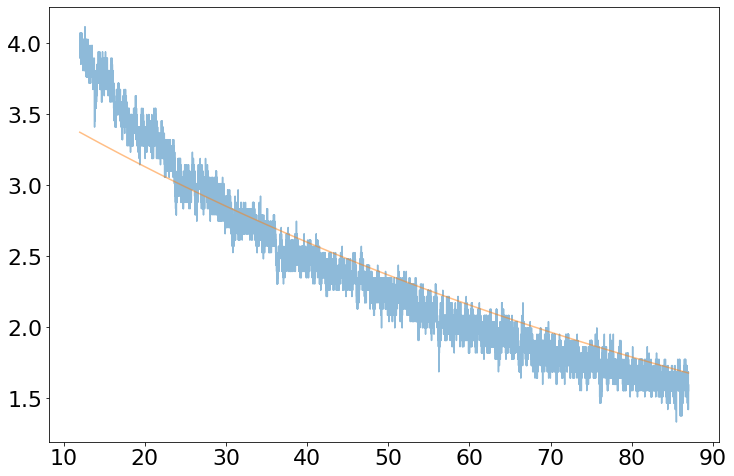

In [261]:
popt, pcov = curve_fit(funcJustExp, timeList[10000:50000],anodeList[2][10000:50000],bounds=([0,0,0], [1000,1000,1000]))
print(popt)
print(pcov)
fig, ax = plt.subplots()
funcList=funcJustExp(timeList[10000:25000],*popt)
ax.plot(timeList[10000:25000],anodeList[1][10000:25000],label="Raw",alpha=0.5)
ax.plot(timeList[10000:25000],funcList,label="Func",alpha=0.5)

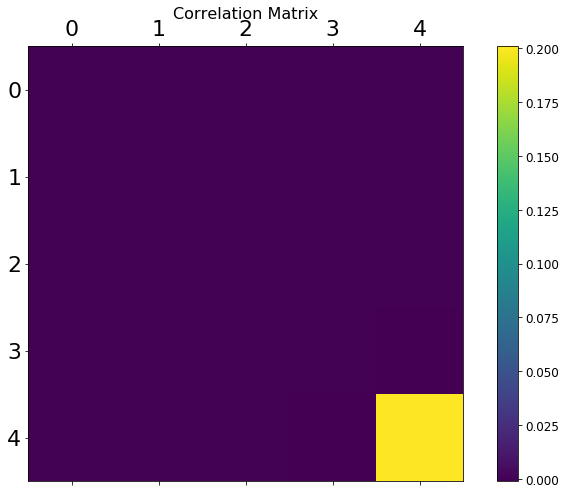

In [250]:
f,ax = plt.subplots()
im=ax.matshow(pcov)
cb = plt.colorbar(im)
cb.ax.tick_params(labelsize=12)
ax.set_title('Correlation Matrix', fontsize=16);